#### End-to-End Guide to Building a Credit Scorecard Using Machine Learning

https://towardsdatascience.com/end-to-end-guide-to-building-a-credit-scorecard-using-machine-learning-6502d8bb765a

In [2]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = { 'pandas','numpy', 'matplotlib', 'seaborn','toad','pickle','sklearn'}
missing = required - installedPackages
if missing:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install toad
    !pip install pickle
    !pip install sklearn

c:\Users\santiago.bruzza\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle


# 1. Data Preprocessing

In [4]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data


def target_info(df_target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    proportion_true=str(round(sum(df_target_column == True) / len(df_target_column), 2) * 100)
    
    proportion_false=str(round(sum(df_target_column == False) / len(df_target_column), 3) * 100)
    
    print('There are total {} records in our data.'.format(len(df_target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(df_target_column == True)))
    print('Proportion (Fraud): {}'.format(proportion_true
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(df_target_column == False)))
    print('Proportion (Not Fraud): {}'.format(proportion_false
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=df_target_column.value_counts().index, y=df_target_column.value_counts(), palette = 'Set2')
    plt.title('Not Fraud vs Fraud Counts')
    plt.ylabel('Count')

    total = float(len(df_target_column))
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 3,
                       '{:.1%}'.format(height / total),
                       ha='center', va='bottom')

    return proportion_true



In [5]:
# use pandas to load the csv file
data = pd.read_csv('UCI_Credit_Card.csv')

In [6]:
# check the size of the data
data.shape

(30000, 25)

In [7]:
# check few lines
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [9]:
#use the world 'label'
data['label']=data['default.payment.next.month']
data=data.drop(columns=['default.payment.next.month'])

There are total 30000 records in our data.
Is Fraud:
Count: 6636
Proportion (Fraud): 22.0%
Not Fraud:
Count: 23364
Proportion (Not Fraud): 77.9%


'22.0'

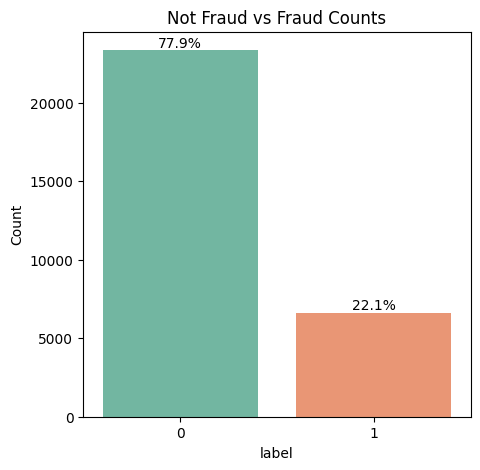

In [10]:
#check the fraud proportion of the data
target_info(data['label'])

In [11]:
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']

In [12]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [13]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [14]:
train.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [15]:
test.label.value_counts()

label
0    5953
1    1548
Name: count, dtype: int64

# 2. Feature Filtering

In [16]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the Information Value (IV) is smaller than the threshold, delete the features

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))


keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [17]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [18]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [19]:
df_iv.shape

(22, 2)

In [20]:
df_iv.head(30)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_3,0.401513
3,PAY_4,0.349813
4,PAY_5,0.340014
5,PAY_6,0.282692
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


# 3. Feature Binning
Feature binning is to transform a continuous or numerical variable into a categorical feature.
* It simplifies the logistic regression model and reduces the risk of model overfitting
* Logistic regression is a generalized linear model, and its expressive ability is limited; Feature binning can introduce nonlinearity into the model, which can improve the expressive ability of the model and help better model fitting
* The discretized features are very robust to abnormal data: for example, a feature is 1 if age > 30, and 0 otherwise. If the features are not discretized, an abnormal data point "300 years old" will impact the model fitting
* It can treat null data as an individual class

In [21]:
train_selected.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [22]:
train_selected.shape

(22499, 23)

### Steps for feature binning:
#### Step 1. Initialization: c = toad.transform.Combiner() 
#### Step 2. Training binning: 
c.fit(dataframe, 
      y = 'target', 
      method = 'chi', 
      min_samples = 0.05, 
      n_bins = None, 
      empty_separate = False)
* y: target column
* method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
* min_samples: Each box contains the least number of samples, which can be a number or a proportion 
* n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
* empty_separate: Whether to separate empty boxes separately 

#### Step 3. check binning nodes: c.export() 
#### Step 4. Manually adjust binning: c.load(dict) 
#### Step 5. Apply binning results: c.transform(dataframe, labels=False)
* labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).

In [23]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

3.3417073567708333


In [24]:
combiner

In [25]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [26]:
filename

'CreditScore_save1_combiner.pkl'

In [27]:
# load the model from disk
#combiner = pickle.load(open(filename, 'rb'))

In [28]:
#output binning
bins = combiner.export()

In [29]:
len(bins)

21

In [30]:
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501.0],
 'BILL_AMT2': [2400.0, 8287.0, 35213.0],
 'BILL_AMT3': [2400.0, 7458.0, 81890.0],
 'BILL_AMT4': [2501.0],
 'BILL_AMT5': [2395.0, 8110.0, 35288.0],
 'BILL_AMT6': [19195.0, 50442.0],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [31]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

In [32]:
train_selected_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0,1,0,4,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,1,2,2,2,2,3,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,2,1,2,2,2,2,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,2,1,2,2,2,2,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,1,1,1,2,2,2,...,1,2,0,1,4,2,3,1,2,0


In [33]:
test_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,7,1,3,2,1,2,1,2,2,...,1,3,2,2,2,2,3,2,6,0
1,22501,5,1,2,1,1,1,1,1,1,...,1,0,0,0,1,2,2,2,5,0
2,22502,6,0,2,2,1,2,2,2,2,...,1,3,1,1,2,1,2,2,5,0
3,22503,1,1,3,2,1,3,3,3,2,...,1,2,1,1,2,0,0,1,2,1
4,22504,6,1,2,2,1,2,2,2,2,...,1,3,2,2,3,2,3,2,6,1


In [34]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

21

<Axes: xlabel='PAY_AMT1', ylabel='prop'>

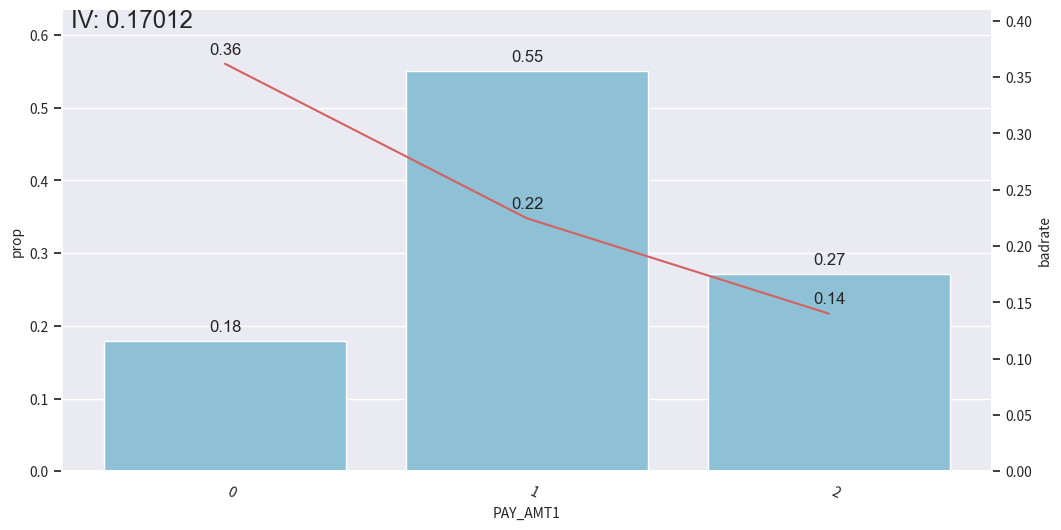

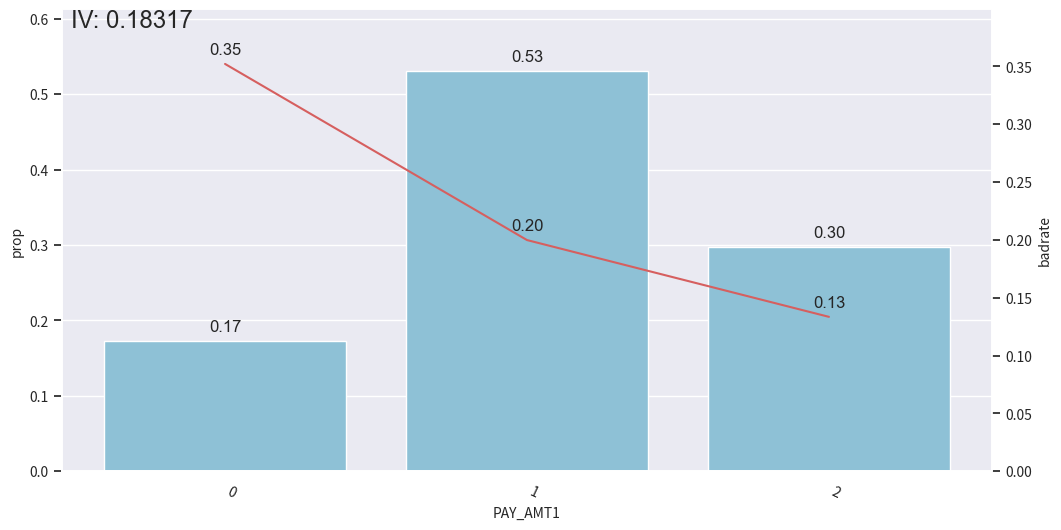

In [35]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

In [36]:
#setting rules
#rule = {'PAY_AMT1':[['0', 'nan'],['1'], ['2'], ['3']]}

#Adjust binning
#c.set_rules(rule)

In [37]:
train_selected_bin.PAY_0.describe()

count    22499.000000
mean         1.988711
std          1.038531
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: PAY_0, dtype: float64

# 4. Transform to WOE

In [38]:
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

In [39]:
train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [40]:
final_data_woe = pd.concat([train_woe,test_woe])

In [41]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [42]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]

In [43]:
len(features_use)

21

## Calculate PSI
* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.2

In [44]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values()
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

In [45]:
psi_df

,feature,psi
0,EDUCATION,0.000258
1,BILL_AMT4,0.000330
2,BILL_AMT6,0.001591
3,BILL_AMT5,0.002520
4,BILL_AMT1,0.002634
5,PAY_AMT5,0.003066
6,PAY_AMT1,0.003402
7,PAY_AMT4,0.004556
8,BILL_AMT2,0.005398
9,PAY_AMT6,0.007230


In [46]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

In [47]:
psi_remove

[]

In [48]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i) 

In [49]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [50]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [51]:
print(final_data_woe.shape)

(30000, 23)


In [52]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

# 5. Output IV

In [53]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

In [54]:
df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')

In [55]:
df_iv

,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734
5,PAY_6,0.285164
6,LIMIT_BAL,0.181621
7,PAY_AMT1,0.173425
8,PAY_AMT2,0.162703
9,PAY_AMT3,0.114630


In [56]:
#save 4: information value after woe transformation
df_iv.to_csv('CreditScore_save4_IV.csv')

# 6. Model Tuning

In [59]:
def check_train_test_auc(x_train,y_train,x_test,y_test):

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report

    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(lr, x_test, y_test, color='blue', ax=ax)

## Logistic Regression

train KS 0.40988185783295383
train AUC 0.7703247777375613
Test KS 0.4264763906414198
Test AUC 0.7834676433960946


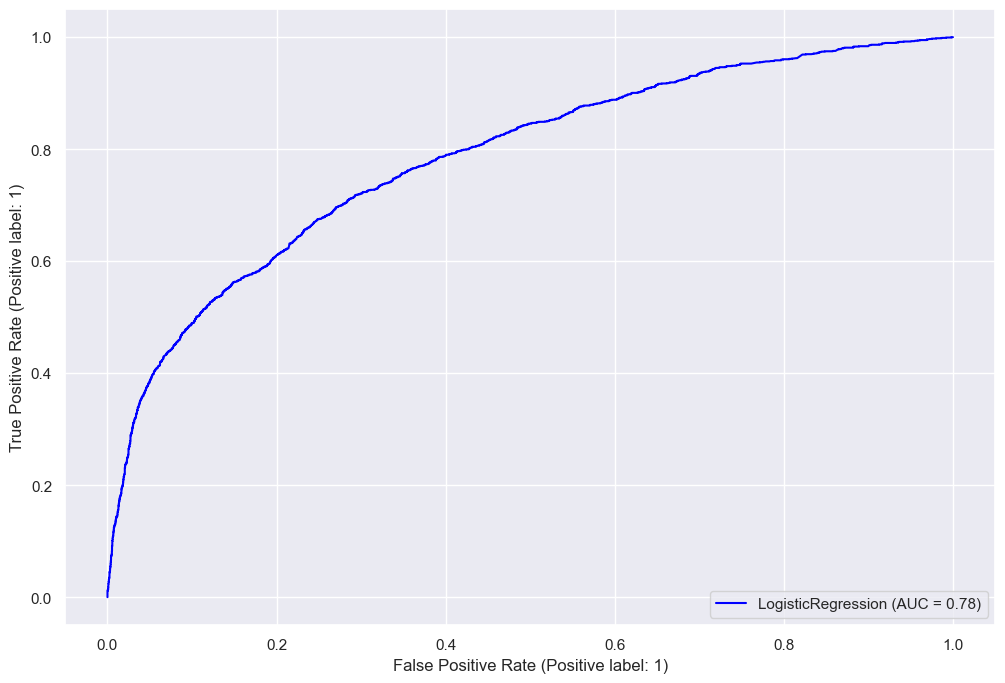

In [60]:
#train & test
check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'],
                     x_test =test_woe[features_use] ,y_test = test_woe['label'])

In [73]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    tp, fn, fp, tn = confusion_matrix(label,predictions,labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print('accuracy: ',accuracy)
    recall = tp/(tp+fn)
    print('（recall）: ',recall)
    precision = tp/(tp+fp)
    print('（precision）: ',precision)
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2*precision*recall/(precision+recall)
    print('F1 score: ',f1)
    
    print(classification_report(label, predictions))
    
    print('balanced_accuracy_score: ',balanced_accuracy_score(label,predictions))
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    start = time.time()
    x_train = df_train[features_name]
    y_train = df_train['label']

    x_test  = df_test[features_name]
    y_test  = df_test['label']

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label = y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances=pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns=['feature_name','feature_importance']
    feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,15))

    sns_plot1=sns.barplot(x=feat_importances.feature_importance, y=feat_importances.feature_name,estimator=sum)
    plt.title("Features Importance",size=18)
    plt.ylabel('', size = 15)
    plt.tick_params(labelsize=18)
    return feat_importances,model,x_train,y_train,x_test,y_test

## Train a GBDT and check the feauture importance table

True Positive： 542
True Negative： 5725
False Positive： 228
False Negative： 1006
accuracy:  0.8354886015197973
（recall）:  0.35012919896640826
（precision）:  0.7038961038961039
F1 score:  0.46764452113891286
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.70      0.35      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.69      7501
weighted avg       0.82      0.84      0.81      7501

balanced_accuracy_score:  0.6559145910840776


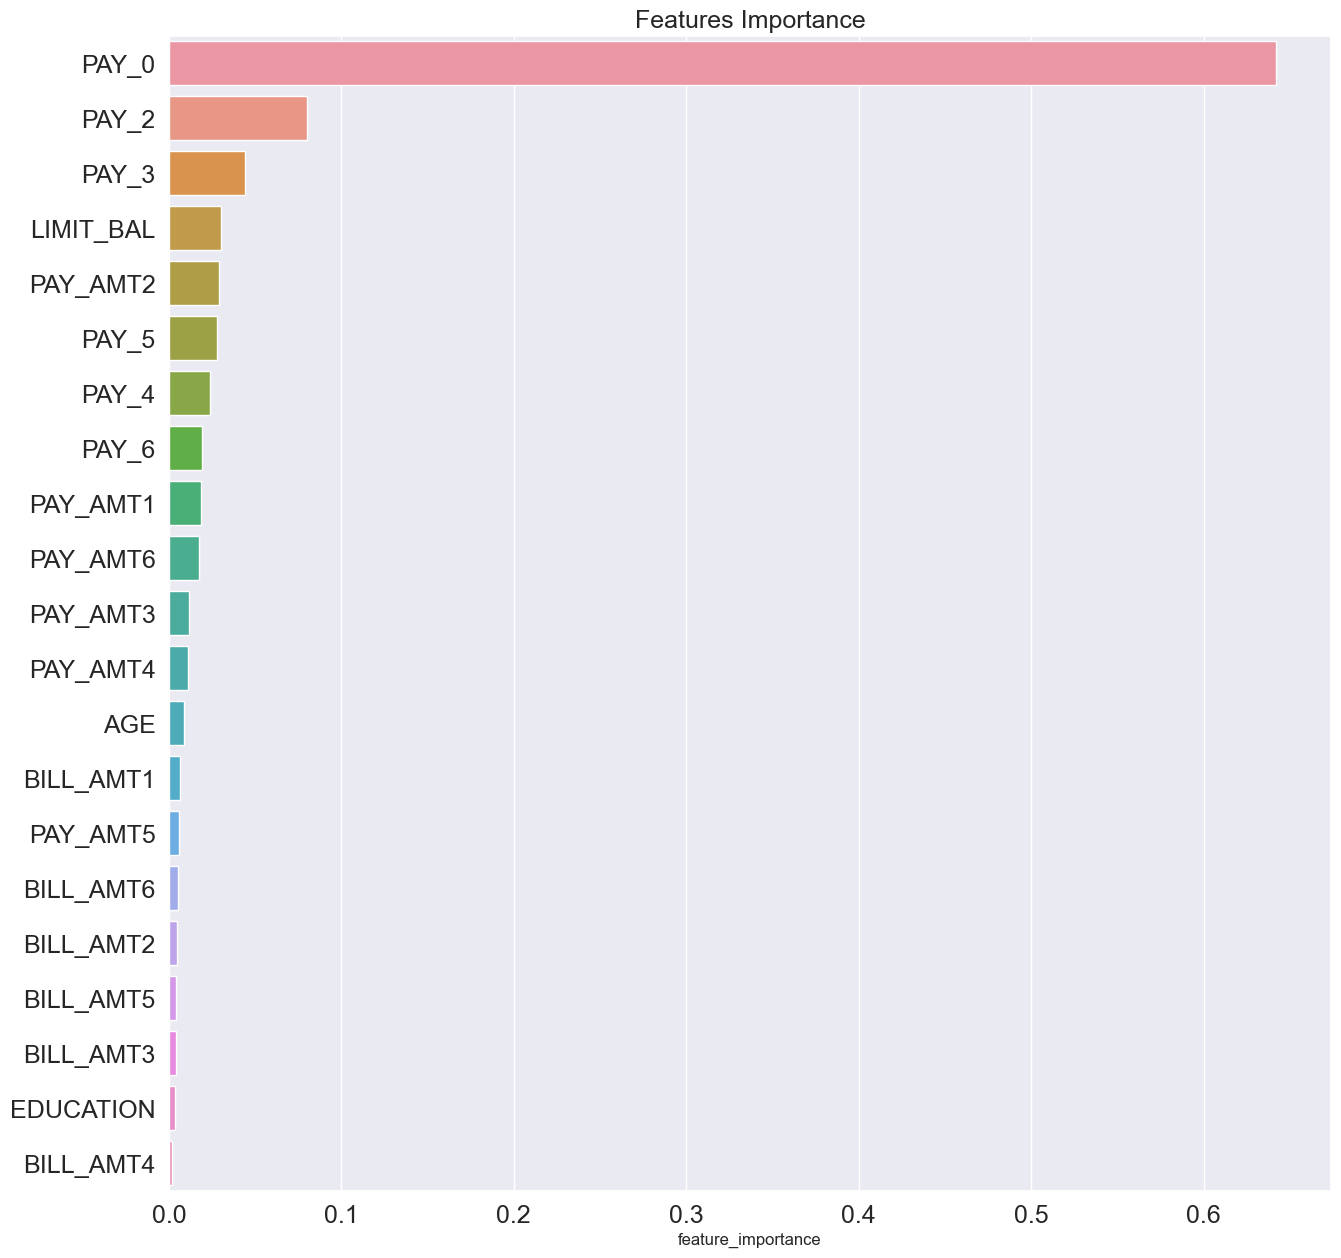

In [74]:
fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,
                df_test=test_woe,
                features_name=features_use)

In [75]:
fet_importance_GBDT_reason

,feature_name,feature_importance
19,PAY_0,0.641879
14,PAY_2,0.080198
13,PAY_3,0.044386
17,LIMIT_BAL,0.030078
11,PAY_AMT2,0.028890
15,PAY_5,0.027666
12,PAY_4,0.023903
18,PAY_6,0.019000
6,PAY_AMT1,0.018523
9,PAY_AMT6,0.017613


In [76]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

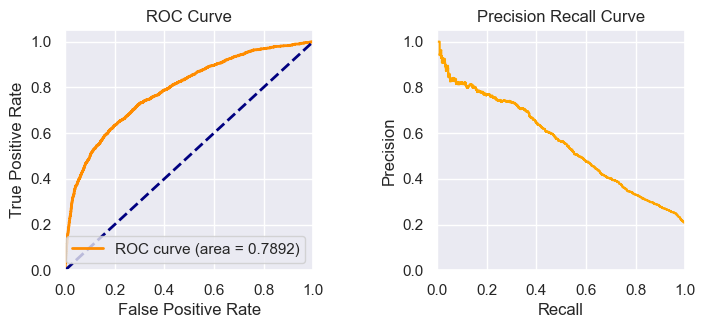

In [77]:
probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 7. Model Production

In [78]:
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['label']
x_test =test_woe[features_use] 
y_test = test_woe['label']

In [79]:
#Train LR
#lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

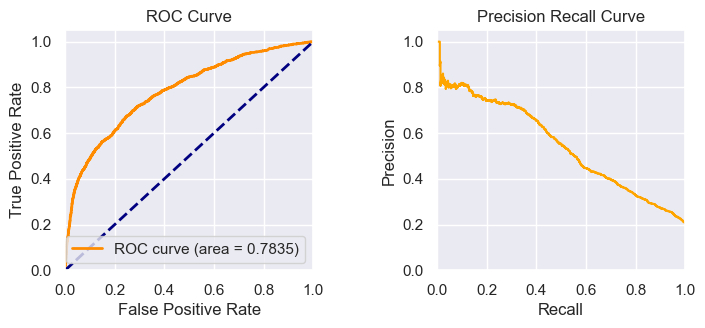

In [80]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 8. Scorecard Generation

In [81]:
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x0000018DD382DF50>,
          pdo=80,
          transer=<toad.transform.WOETransformer object at 0x0000018DD4C7CAD0>)

In [82]:
# save 5: save the model to disk
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [83]:
#inference on test data
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

In [84]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    30000.000000
mean       617.559238
std        118.265235
min        168.851703
25%        578.204047
50%        654.175758
75%        696.461008
max        818.460370
Name: CreditScore, dtype: float64

In [85]:
#output the scorecard
final_card_score=card.export()
len(final_card_score)

21

In [88]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df= pd.concat([score_card_df,temp])
score_card_df.head(30)

,variable,binning,score
0,EDUCATION,[-inf ~ 2),29.66
1,EDUCATION,[2 ~ inf),27.20
0,BILL_AMT4,[-inf ~ 2501.0),28.21
1,BILL_AMT4,[2501.0 ~ inf),27.97
0,BILL_AMT6,[-inf ~ 19195.0),27.33
1,BILL_AMT6,[19195.0 ~ 50442.0),31.37
2,BILL_AMT6,[50442.0 ~ inf),26.23
0,BILL_AMT5,[-inf ~ 2395.0),28.16
1,BILL_AMT5,[2395.0 ~ 8110.0),32.85
2,BILL_AMT5,[8110.0 ~ 35288.0),25.20


In [89]:
#save 6: save the scorcard
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

# 9. Distribution Analysis

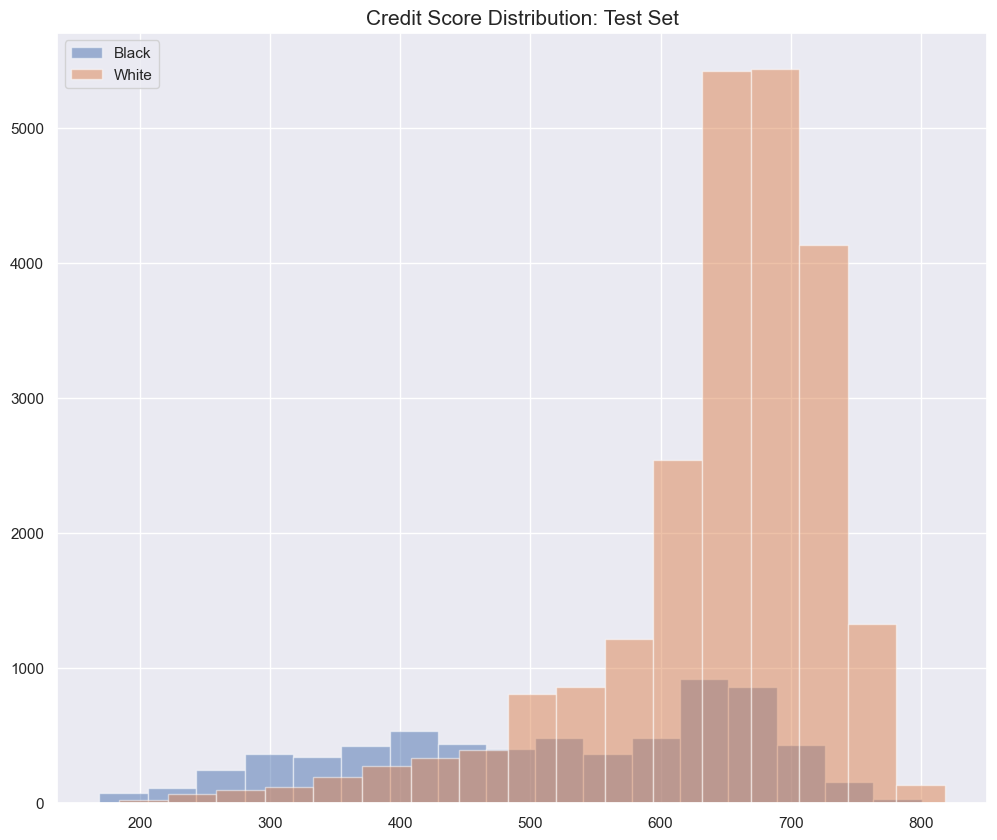

In [90]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((data['CreditScore'].max() - data['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(data[data.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(data[data.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

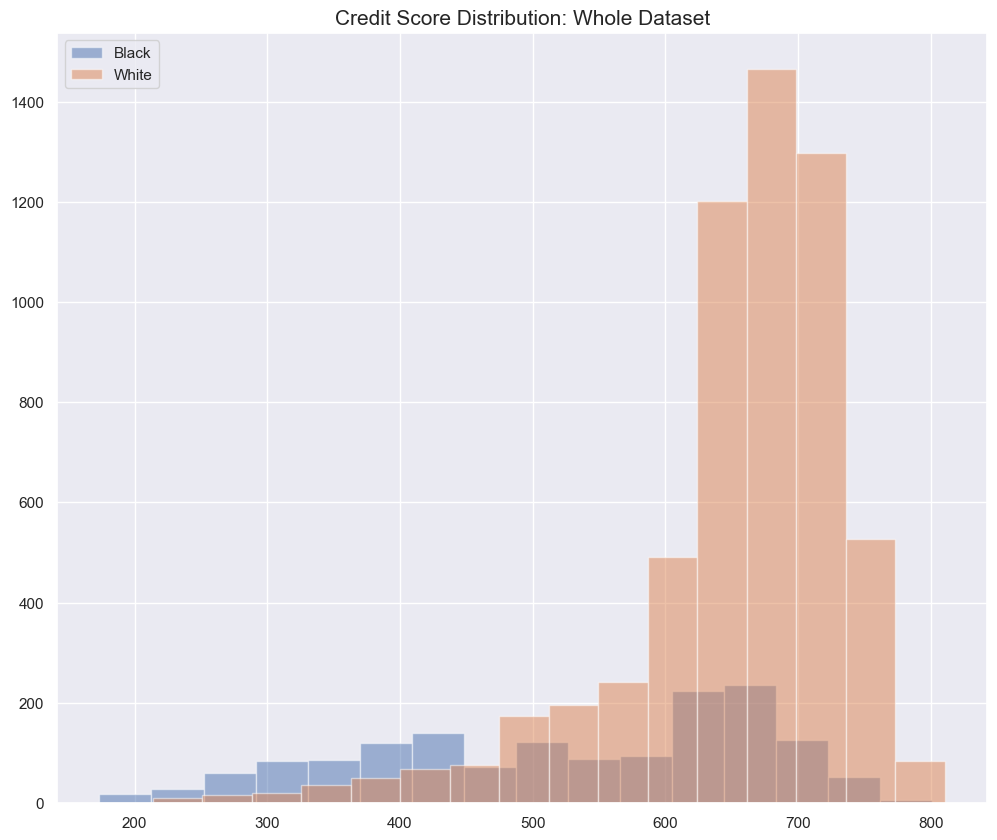

In [91]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

# 10. Threshold Tuning

In [92]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,    
    level_2 = 250,    
    level_3 = 300,    
    level_4 = 350,    
    level_5 = 400,    
    level_6 = 450,
    level_7 = 500,
    level_8 = 800):
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)
        
    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.label==1].groupby(target_col)['label'].count()/ test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

In [93]:
test.CreditScore.describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

### Threshold Tuning & Trade-off between loss & Coverage

In [94]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -1000,
    level_0 = 250,
    level_1 = 300,    
    level_2 = 400,    
    level_3 = 500,    
    level_4 = 580,    
    level_5 = 630,    
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
                )

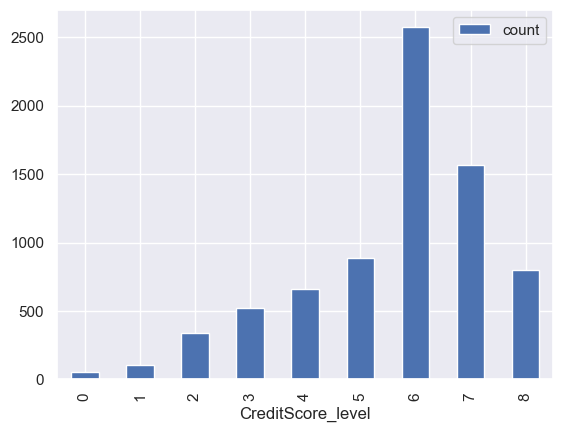

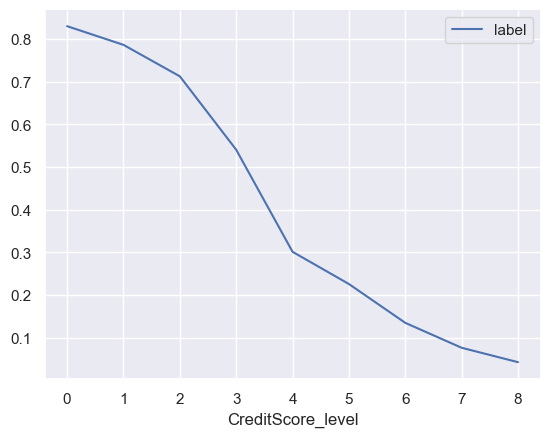

In [95]:
plot_bts_level_loss(test,target_col='CreditScore_level')

In [96]:
sum(test[test.label==1].CreditScore_level==7)

120

In [97]:
def get_loss_coverage(test,target_level):
    
    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].label.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)
    
    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].label.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)
    
    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)
    
     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)
    
    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].label.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)
    
    
    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].label.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)
    
    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].label.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)
    
    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].label.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)
    
    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].label.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [98]:
get_loss_coverage(test,target_level='CreditScore_level')

Level 8: Loss is  0.04271356783919598 ; Coverage is  0.12800268772047707
Level 7-Level 8: Loss is  0.0650887573964497 ; Coverage is  0.3715773559549807
Level 6-Level 8: Loss is  0.10143753796315043 ; Coverage is  0.745506467327398
Level 5-Level 8: Loss is  0.1204323211528564 ; Coverage is  0.8612464303712414
Level 4-Level 8: Loss is  0.13876040703052728 ; Coverage is  0.938350411557198
Level 3-Level 8: Loss is  0.1684751570531125 ; Coverage is  0.97833025365362
Level 2-Level 8: Loss is  0.19373723621511232 ; Coverage is  0.9947925415756761
Level 1-Level 8: Loss is  0.20193340494092374 ; Coverage is  0.9984881572316479
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [99]:
#save 7: save the scorcard
data.to_csv('OrderScore_save7_whole_data.csv',index=False)